In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import datasist as ds                            #For data cleaning 
import pickle
# Show plots in jupyter notebook
%matplotlib inline
# Set plot style
sns.set(color_codes=True)
# Set maximum number of columns to be displayed
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',150)
plt.style.use('ggplot')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Modeling
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold, cross_val_score,RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,LabelEncoder,StandardScaler

In [2]:
#Load data
raw_data = pd.read_csv('au_train.csv')
raw_data.head(4)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K


# DATA PRE-PROCESSING

In [3]:
# Clean up column names
raw_data = raw_data.rename(columns=lambda x:x.lower().replace('-','_'))

# The column name "Class" is a key word in python so it needs to be renamed
raw_data.columns = raw_data.columns.str.replace('class', 'salary_class')

In [4]:
def remove_bad_characters(df):
    
    # iterating over categorical columns
    for i in df[ds.structdata.get_cat_feats(raw_data)]:
        # applying strip function on column
        df[i] = df[i].map(str.strip)
    # Replace "?" with NaN
    df = df.replace('?', np.NaN)

        
    return df

# applying bad character remover function on dataframe
clean_df = remove_bad_characters(raw_data)

In [5]:
# Function to check missing value
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'missing_values', 1 : 'percentage'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] >= 0].sort_values(
    'percentage', ascending=False).round(1)
    print("Dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

# Check missing values
missing_recs = missing_values_table(clean_df)
display(missing_recs)

Dataframe has 15 columns.
There are 3 columns that have missing values.


,missing_values,percentage
occupation,1843,5.7
worksalary_class,1836,5.6
native_country,583,1.8
age,0,0.0
fnlwgt,0,0.0
education,0,0.0
education_num,0,0.0
marital_status,0,0.0
relationship,0,0.0
race,0,0.0


In [6]:
# Missing Values are only in the categorical variable so this will be filled using the most common class
clean_df = clean_df.apply(lambda x: x.fillna(x.value_counts().index[0]))
missing_values_table(clean_df)

Dataframe has 15 columns.
There are 0 columns that have missing values.


,missing_values,percentage
age,0,0.0
worksalary_class,0,0.0
fnlwgt,0,0.0
education,0,0.0
education_num,0,0.0
marital_status,0,0.0
occupation,0,0.0
relationship,0,0.0
race,0,0.0
sex,0,0.0


In [7]:
# Function to print duplicated entries
def get_duplicated(df):
    # generate count statistics of duplicate entries
    if len(df[df.duplicated()]) > 0:
        print("No. of duplicated entries: ", len(df[df.duplicated()]))
        print("Data Dimension: ", df.shape)
        df = df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head(10)
        
    else:
        print("No duplicated entries found")
    return df
        
# Print redundant rows
get_duplicated(clean_df)

No. of duplicated entries:  24
Data Dimension:  (32561, 15)


,age,worksalary_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary_class
17673,19,Private,97261,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,<=50K
18698,19,Private,97261,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,<=50K
6990,19,Private,138153,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K
21318,19,Private,138153,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K
15189,19,Private,146679,Some-college,10,Never-married,Exec-managerial,Own-child,Black,Male,0,0,30,United-States,<=50K
21490,19,Private,146679,Some-college,10,Never-married,Exec-managerial,Own-child,Black,Male,0,0,30,United-States,<=50K
3917,19,Private,251579,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,14,United-States,<=50K
31993,19,Private,251579,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,14,United-States,<=50K
5805,20,Private,107658,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,10,United-States,<=50K
11631,20,Private,107658,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,10,United-States,<=50K


In [8]:
# Drop duplicated records
clean_df = clean_df.drop_duplicates()

# Data Engineering

## Formatting and Cardinality Reduction

In [9]:
clean_df.worksalary_class.value_counts()

Private             24509
Self-emp-not-inc     2540
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: worksalary_class, dtype: int64

In [10]:
#Reduce cardinality of the salary_class variable
def workclass(df):
    workclass_mapper = {
        'Private': "Private",
        'Self-emp-not-inc': "Self_employed",
        'Federal-gov': "Civil_servant",
        'State-gov': "Civil_servant",
        'Local-gov': "Civil_servant",
        'Self-emp-inc': "Self_employed",
        'Without-pay': "Unemployed",
        'Never-worked': "Unemployed"
        }
    
    df["worksalary_class"] = df["worksalary_class"].map(workclass_mapper)
    
    return df

# Apply function
clean_df = workclass(clean_df)

In [11]:
clean_df.education.value_counts()

HS-grad         10494
Some-college     7282
Bachelors        5353
Masters          1722
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           645
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           332
1st-4th           166
Preschool          50
Name: education, dtype: int64

In [12]:
#Reduce cardinality of the education variable
def education(df):
    education_mapper = {
        'HS-grad': "Secondary_edu",
        'Some-college': "Secondary_edu",
        'Bachelors': "Graduate",
        'Masters': "Post_Grad",
        'Assoc-voc': "Secondary_edu",
        '11th': "Primary_education",
        'Assoc-acdm': "Secondary_edu",
        '10th': "Primary_education",
        '7th-8th': "Primary_education",
        'Prof-school': "Secondary_edu",
        '9th': "Primary_education",
        '12th': "Primary_education",
        'Doctorate': "PhD",
        '5th-6th': "Primary_education",
        '1st-4th': "Primary_education",
        'Preschool': "Primary_education"
        }
    
    df["education"] = df["education"].map(education_mapper)
    
    return df

# Apply function
clean_df = education(clean_df)

In [13]:
clean_df.marital_status.value_counts()

Married-civ-spouse       14970
Never-married            10667
Divorced                  4441
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital_status, dtype: int64

In [14]:
#Reduce cardinality of the marital status variable
def marital_status(df):
    Marital_status_mapper = {
        'Married-civ-spouse': "Married",
        'Never-married': "Single",
        'Divorced': "Unmarried",
        'Separated': "Unmarried",
        'Widowed': "Widowed",
        'Married-spouse-absent': "Married",
        'Married-AF-spouse': "Married"
        }
    
    df["marital_status"] = df["marital_status"].map(Marital_status_mapper)
    return df

# Apply function
clean_df = marital_status(clean_df)

In [15]:
clean_df.occupation.value_counts()

Prof-specialty       5979
Craft-repair         4094
Exec-managerial      4065
Adm-clerical         3768
Sales                3650
Other-service        3291
Machine-op-inspct    2000
Transport-moving     1597
Handlers-cleaners    1369
Farming-fishing       992
Tech-support          927
Protective-serv       649
Priv-house-serv       147
Armed-Forces            9
Name: occupation, dtype: int64

In [16]:
clean_df.relationship.value_counts()

Husband           13187
Not-in-family      8292
Own-child          5064
Unmarried          3445
Wife               1568
Other-relative      981
Name: relationship, dtype: int64

In [17]:
clean_df.native_country.value_counts()

United-States                 29735
Mexico                          639
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Japan                            62
Guatemala                        62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                           29
Greece                      

In [18]:
#Reduce cardinality of the native_country variable
def native_country(df):
    for i in df["native_country"]:
        if i != "United-States":
            df["native_country"] = df["native_country"].replace(i, "Others")
        else:
            pass
    
    return df

# Apply function
clean_df = native_country(clean_df)

# Handling outliers

In [19]:
# Get count of outlier values in every column
def outlier_value_count(df):
    num_feats = ds.structdata.get_num_feats(df)
    Q1=df[num_feats].quantile(0.05)
    Q3=df[num_feats].quantile(0.95)
    IQR=Q3-Q1
    lower_bound=Q1 - 1.5 * IQR
    upper_bound=Q3 + 1.5 * IQR
    return ((df[num_feats] < lower_bound) | (df[num_feats] > upper_bound)).sum()


#Show outlier count in entire data
# Outlier value count of historical customer data
print("Outlier value count of loan data")
outlier_value_count(clean_df)

Outlier value count of loan data


age                  0
fnlwgt              20
education_num        0
capital_gain       707
capital_loss      1519
hours_per_week       0
dtype: int64

**Outliers where corrected by setting the lower and upper boundary of every numeric variable to the 5th and 95th percentile values respectively**

In [20]:
num_col = clean_df.select_dtypes(include=['int64','float64']).columns.tolist()

clean_df[num_col] = clean_df[num_col].apply(lambda x: x.clip(*x.quantile([0.05, 0.95])))
outlier_value_count(clean_df)

age               0
fnlwgt            0
education_num     0
capital_gain      0
capital_loss      0
hours_per_week    0
dtype: int64

In [21]:
clean_df.isnull().sum()

age                 0
worksalary_class    0
fnlwgt              0
education           0
education_num       0
marital_status      0
occupation          0
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country      0
salary_class        0
dtype: int64

## Pre-Process Test Data

In [22]:
def preproc(df):
    # Clean up column names
    df = df.rename(columns=lambda x:x.lower().replace('-','_'))

    # The column name "Class" is a key word in python so it needs to be renamed
    df.columns = df.columns.str.replace('class', 'salary_class')
    
    # applying bad character remover function on dataframe
    df = remove_bad_characters(df)
    
    # fill missing values using the most common class
    df =df.apply(lambda x: x.fillna(x.value_counts().index[0]))
    
    # Drop duplicated records
    df = df.drop_duplicates()
    
    #Reduce cardinality of workclass variable
    df = workclass(df)
    
    #Reduce cardinality of education variable
    df = education(df)
    
    #Reduce cardinality of marital_status variable
    df = marital_status(df)
    
    #Reduce cardinality of native_country variable
    df = native_country(df)
    
    # Handle outliers
    num_col = df.select_dtypes(include=['int64','float64']).columns.tolist()
    df[num_col] = df[num_col].apply(lambda x: x.clip(*x.quantile([0.05, 0.95])))
    
    df.drop('salary_class', axis=1, inplace=True)
    
    return df

# Load Test Set
#Load loan data
test_df = pd.read_csv('au_test.csv')

# Apply function to clean test set
test_df = preproc(test_df)

print(test_df.shape)

test_df.head(5)

(16276, 14)


,age,worksalary_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,25,Private,226802.0,Primary_education,7,Single,Machine-op-inspct,Own-child,Black,Male,0,0,40.0,United-States
1,38,Private,89814.0,Secondary_edu,9,Married,Farming-fishing,Husband,White,Male,0,0,50.0,United-States
2,28,Civil_servant,336951.0,Secondary_edu,12,Married,Protective-serv,Husband,White,Male,0,0,40.0,United-States
3,44,Private,160323.0,Secondary_edu,10,Married,Machine-op-inspct,Husband,Black,Male,4865,0,40.0,United-States
4,19,Private,103497.0,Secondary_edu,10,Single,Prof-specialty,Own-child,White,Female,0,0,30.0,United-States


In [68]:
test_df.to_csv("cleaned_test_df.csv")
clean_df.to_csv("cleaned_train_df.csv")

In [69]:
#Load data
train_df = pd.read_csv('cleaned_train_df.csv')
train_df.drop('Unnamed: 0', axis=1, inplace=True)

test_df = pd.read_csv('cleaned_test_df.csv')
test_df.drop(['Unnamed: 0'], axis=1, inplace=True)


train_df

,age,worksalary_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary_class
0,39,Civil_servant,77516.0,Graduate,13,Single,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self_employed,83311.0,Graduate,13,Married,Exec-managerial,Husband,White,Male,0,0,18,United-States,<=50K
2,38,Private,215646.0,Secondary_edu,9,Unmarried,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721.0,Primary_education,7,Married,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409.0,Graduate,13,Married,Prof-specialty,Wife,Black,Female,0,0,40,Others,<=50K
5,37,Private,284582.0,Post_Grad,14,Married,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187.0,Primary_education,5,Married,Other-service,Not-in-family,Black,Female,0,0,18,Others,<=50K
7,52,Self_employed,209642.0,Secondary_edu,9,Married,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781.0,Post_Grad,14,Single,Prof-specialty,Not-in-family,White,Female,5013,0,50,United-States,>50K
9,42,Private,159449.0,Graduate,13,Married,Exec-managerial,Husband,White,Male,5013,0,40,United-States,>50K


In [70]:
print(f'shape of the test data is:', test_df.shape)
print(f'shape of the training data is:', train_df.shape)

shape of the test data is: (16276, 14)
shape of the training data is: (32537, 15)


## Data Splitting

**Ordinal encoding was used to encode the target to preserve the order of the grades**

* **Split ratio = 80:20**

In [71]:
train_df.columns

Index(['age', 'worksalary_class', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'salary_class'],
      dtype='object')

In [72]:
train_df.salary_class.value_counts()

<=50K    24698
>50K      7839
Name: salary_class, dtype: int64

In [73]:
# Format classes of employment length variable
class_map = {
    '<=50K': 0,
    '>50K': 1
}

train_df.salary_class = train_df.salary_class.map(class_map)
train_df.head(4)

,age,worksalary_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary_class
0,39,Civil_servant,77516.0,Graduate,13,Single,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self_employed,83311.0,Graduate,13,Married,Exec-managerial,Husband,White,Male,0,0,18,United-States,0
2,38,Private,215646.0,Secondary_edu,9,Unmarried,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721.0,Primary_education,7,Married,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0


In [74]:
# Split data
from sklearn.model_selection import train_test_split
X = train_df.drop(columns=['salary_class'])
y = train_df.salary_class

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((26029, 14), (6508, 14), (26029,), (6508,))

## Handling Class Imbalance

In [75]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
under_50k = X[X.salary_class == 0]
over_50k = X[X.salary_class == 1]

# upsample minority
over_50k_upsampled = resample(over_50k,
                          replace=True, # sample with replacement
                          n_samples=len(under_50k), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([under_50k, over_50k_upsampled])

# check new class counts
upsampled.salary_class.value_counts()

1    19758
0    19758
Name: salary_class, dtype: int64

In [76]:
y_train = upsampled.salary_class
X_train = upsampled.drop('salary_class', axis=1)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((39516, 14), (6508, 14), (39516,), (6508,))

# Label Encoding

In [78]:
# from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,LabelEncoder,StandardScaler
# def transform(df):
#     # Assigning numerical values and storing in another column
#     cols = ds.structdata.get_cat_feats(df)
                                                       
#     # Encode Categorical Columns
#     le = LabelEncoder()
#     df[cols] = df[cols].apply(le.fit_transform)
        
#     return df

In [89]:
def transform(df):
    le = LabelEncoder()
    for i in df.columns:
        if (df[i].dtypes == 'object'):
            df[i] = le.fit_transform(df[i])
    return df

In [90]:
# Transform data
X_train = transform(X_train)
X_test = transform(X_test)
test = transform(test_df)

In [91]:
print('---------training set--------------------')
display(X_train.head(4))
print('---------Validation set--------------------')
display(X_test.head(4))
print('---------test set--------------------')
display(test.head(4))

---------training set--------------------


,age,worksalary_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
24749,33,1,279173.0,4,9,0,9,0,4,1,0,0,60,1
2754,63,2,184335.0,3,5,0,4,0,4,1,0,0,30,1
5296,33,1,100135.0,4,9,0,0,5,4,0,0,0,25,1
10327,36,1,116608.0,4,9,2,6,4,4,0,0,0,38,1


---------Validation set--------------------


,age,worksalary_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
20325,27,1,178709.0,2,14,1,6,1,4,0,0,0,40,1
23863,51,0,379699.2,0,13,0,0,0,4,1,0,0,50,1
19987,34,1,202498.0,3,8,0,7,0,4,1,0,0,40,0
21430,31,1,133861.0,4,12,2,3,1,4,1,0,0,40,1


---------test set--------------------


,age,worksalary_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,25,1,226802.0,3,7,1,6,3,2,1,0,0,40.0,1
1,38,1,89814.0,4,9,0,4,0,4,1,0,0,50.0,1
2,28,0,336951.0,4,12,0,10,0,4,1,0,0,40.0,1
3,44,1,160323.0,4,10,0,6,0,2,1,4865,0,40.0,1


# Feature Selection

**The following techniques will be used for feature selection:**
* Recursive feature elimination

**The performance of the models trained using the entire features will be compared to the model trained using each of this feature selection technique.**

## Recursive feature elimination

In [92]:
from sklearn.feature_selection import RFE
model_tree = RandomForestClassifier(random_state=100, n_estimators=50)
sel_rfe_tree = RFE(estimator=model_tree, n_features_to_select=None, step=1)
X_train_rfe_tree = sel_rfe_tree.fit_transform(X_train, y_train)
print(sel_rfe_tree.get_support(indices=True))

[ 0  2  4  5  7 10 12]


In [93]:
rfe_index = [0, 2, 4, 5, 7, 10, 12]
X_train_rfe = X_train.iloc[:,rfe_index]
X_test_rfe = X_test.iloc[:,rfe_index]
print("train shape:",X_train_rfe.shape)
print("test shape", X_test_rfe.shape)

train shape: (39516, 7)
test shape (6508, 7)


# Modeling

**Modeling will be done using only tree-base models.** 

**The following models will be experimented using all features and a subset of features**
* Decision Tree Classifier
* Random Forest Classifier

**Cross-validation techniques will be used to prevent overfitting**

In [94]:
# Function to evaluate models 
def evaluate_model(val_pred, X_test, y_test):
    confusion = confusion_matrix(y_test, val_pred)
    print("confusion matrix:", confusion)

    fig, ax = plt.subplots()
    # create heatmap
    sns.heatmap(confusion, annot=True, fmt='d', cmap='YlGnBu')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

## Decision Tree

### Decision Tree (All features)

In [95]:
def dtree_modeling(x_train, y_train, x_test, y_test, param_grid):
#     cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    tree_clas = DecisionTreeClassifier(random_state=1024)
    models = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=cv, verbose=True)
    models.fit(x_train, y_train)
    print(models.best_params_)
    print("Train data accuracy score: ", models.score(x_train,y_train))
    print("Test data accuracy score: ", models.score(x_test,y_test))
    return models

In [96]:
from plot_metric.functions import BinaryClassification

In [97]:
def dtree_model(x_train, y_train, x_test, y_test, param_grid):
    dtree = dtree_modeling(x_train, y_train, x_test, y_test, param_grid)
    val_pred = dtree.predict(x_test)
    val_pred
    print("classification report :\n",classification_report(val_pred,y_test))

    bc = BinaryClassification(y_test, val_pred, labels=[0, 1])
    # Figures
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    plt.show()


    return evaluate_model(val_pred, x_test, y_test)

Fitting 15 folds for each of 18 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    8.3s finished


{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto'}
Train data accuracy score:  0.7855552181394878
Test data accuracy score:  0.7647510755992625
classification report :
               precision    recall  f1-score   support

           0       0.75      0.93      0.83      3969
           1       0.82      0.51      0.63      2539

    accuracy                           0.76      6508
   macro avg       0.78      0.72      0.73      6508
weighted avg       0.78      0.76      0.75      6508



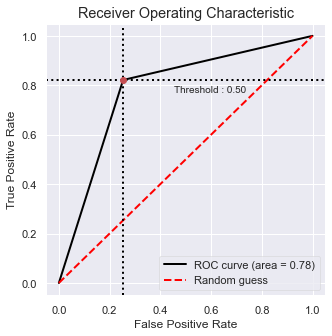

confusion matrix: [[3689 1251]
 [ 280 1288]]


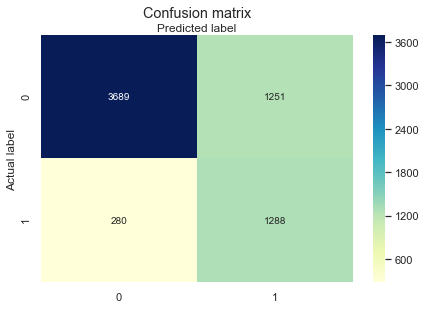

In [98]:
param_grid = {'max_features': ['auto'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7],
              'criterion' :['gini', 'entropy']
             }

dtree_model(X_train, y_train, X_test, y_test, param_grid)

### Decision Tree using Recursive Feature Elimination Variables

Fitting 15 folds for each of 18 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    6.1s finished


{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto'}
Train data accuracy score:  0.798840975807268
Test data accuracy score:  0.7576828518746158
classification report :
               precision    recall  f1-score   support

           0       0.72      0.95      0.82      3731
           1       0.88      0.50      0.64      2777

    accuracy                           0.76      6508
   macro avg       0.80      0.72      0.73      6508
weighted avg       0.79      0.76      0.74      6508



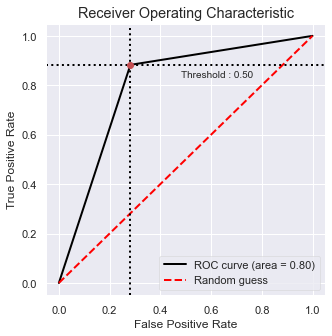

confusion matrix: [[3547 1393]
 [ 184 1384]]


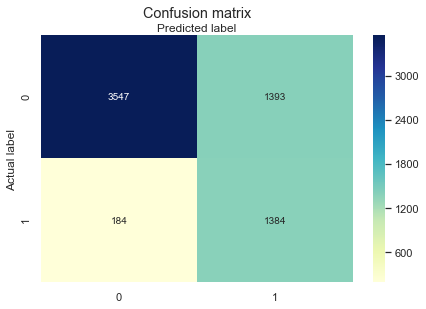

In [99]:
param_grid = {'max_features': ['auto'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7],
              'criterion' :['gini', 'entropy']
             }

dtree_model(X_train_rfe, y_train, X_test_rfe, y_test, param_grid)

## Random Forest Classifier

### Random Forest Classifier (All Features)

In [100]:
def rfc_modeling(classifier, x_train, y_train, x_test, y_test, param, **kwargs):
#     cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    from sklearn.pipeline import Pipeline
    pipeline = Pipeline([('algo',classifier(**kwargs))])
    model = GridSearchCV(pipeline,param,cv=cv,n_jobs=-1,verbose=1)
    model.fit(x_train,y_train)

    print(model.best_params_)
    print("Train data accuracy score: ", model.score(x_train,y_train))
    print("Test data accuracy score: ", model.score(x_test,y_test))
    
    return model

In [101]:
def rfc_model(classifier, X_train, y_train, X_test, y_test, param_rf):
    rfc = rfc_modeling(classifier, X_train, y_train, X_test, y_test, param_rf, n_jobs=-1,random_state=42)
    val_pred = rfc.predict(X_test)
    val_pred
    print("classification report :\n",classification_report(val_pred,y_test))

    # Plot ROC
    bc = BinaryClassification(y_test, val_pred, labels=[0, 1])
    # Figures
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    plt.show()
    
    return evaluate_model(val_pred, X_test, y_test)

In [102]:
# Get class weight
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)

print(class_weight)
print(upsampled.salary_class.value_counts())

[1. 1.]
1    19758
0    19758
Name: salary_class, dtype: int64


Fitting 15 folds for each of 1 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   22.8s finished


{'algo__class_weight': {0: 1, 1: 1}, 'algo__max_depth': 6, 'algo__max_features': 0.5, 'algo__min_samples_leaf': 63, 'algo__n_estimators': 200}
Train data accuracy score:  0.8220720720720721
Test data accuracy score:  0.7854947756607252
classification report :
               precision    recall  f1-score   support

           0       0.75      0.96      0.84      3876
           1       0.89      0.53      0.67      2632

    accuracy                           0.79      6508
   macro avg       0.82      0.74      0.75      6508
weighted avg       0.81      0.79      0.77      6508



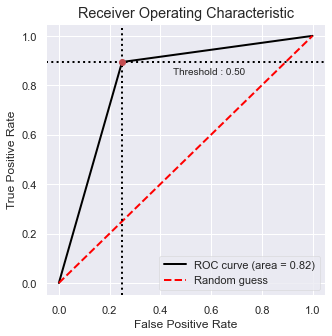

confusion matrix: [[3710 1230]
 [ 166 1402]]


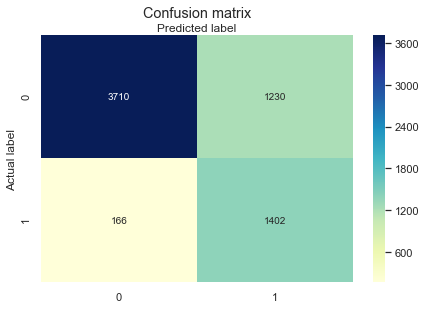

In [103]:
param_rf = {
    'algo__n_estimators':[200],
    'algo__max_depth':[6],
    'algo__max_features':[0.5],
    'algo__min_samples_leaf':[63],
    'algo__class_weight':[{0:1,
                           1:1}]
}

rfc_model(RandomForestClassifier, X_train, y_train, X_test, y_test, param_rf)

### Random Forest using Recursive Feature Elimination

Fitting 15 folds for each of 1 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   13.4s finished


{'algo__class_weight': {0: 1, 1: 1}, 'algo__max_depth': 6, 'algo__max_features': 0.5, 'algo__min_samples_leaf': 63, 'algo__n_estimators': 200}
Train data accuracy score:  0.8223757465330499
Test data accuracy score:  0.784880147510756
classification report :
               precision    recall  f1-score   support

           0       0.75      0.96      0.84      3870
           1       0.89      0.53      0.67      2638

    accuracy                           0.78      6508
   macro avg       0.82      0.74      0.75      6508
weighted avg       0.81      0.78      0.77      6508



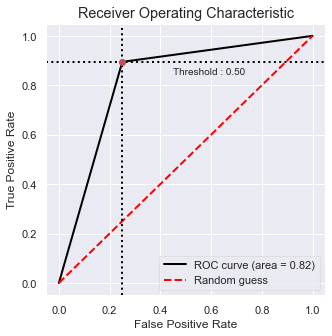

confusion matrix: [[3705 1235]
 [ 165 1403]]


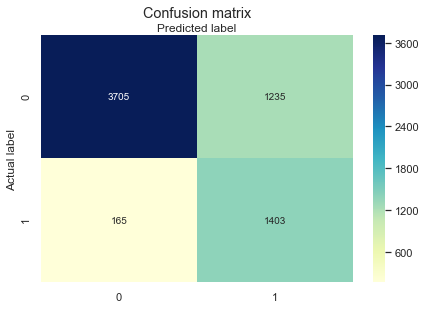

In [104]:
param_rf = {
    'algo__n_estimators':[200],
    'algo__max_depth':[6],
    'algo__max_features':[0.5],
    'algo__min_samples_leaf':[63],
    'algo__class_weight':[{0:1,
                           1:1}]
}

rfc_model(RandomForestClassifier, X_train_rfe, y_train, X_test_rfe, y_test, param_rf)